# Build Metadata.csv

## Columns:

* StationID: str
* lat: float
* lon: float
* availability: list of years: String or Int
* ....

In [3]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

---
# 1) Get a list of available files:

In [4]:
url = "https://www.ndbc.noaa.gov/data/historical/stdmet/"
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
    body = soup.body
else:
    print('Error fetching website.')

In [5]:
pattern = r'\xa0\n(.*?\.txt\.gz)'  # Example: \xa0\n0y2w3h2012.txt.gz
file_names = re.findall(pattern, body.text)
#file_names

In [6]:
available_files = {}

for filename in file_names:

    pattern = r'(.+?)h(\d{4})\.txt\.gz'
    match = re.match(pattern, filename)

    station = match.group(1)
    year = int(match.group(2))

    if station not in available_files:
        available_files[station] = { year }
    else:
        available_files[station].add(year)

In [7]:
# available_files

available_files is a dictionary of stations. The value of each station is a set of the years, where a file exists!

In [8]:
# create a list of all years in the sets
all_years = sorted(list(set.union(*[value for value in available_files.values()])))

# create an empty DataFrame with columns as years and index as dictionary keys
metadata_0 = pd.DataFrame(index=available_files.keys(), columns=all_years)

# fill the DataFrame with Boolean values
for key, value in available_files.items():
    for year in all_years:
        metadata_0.loc[key, year] = year in value

# print the DataFrame
print(metadata_0)

        1970   1971   1972   1973   1974   1975   1976   1977   1978   1979  \
0y2w3  False  False  False  False  False  False  False  False  False  False   
4cONF  False  False  False  False  False  False  False  False  False  False   
4h361  False  False  False  False  False  False  False  False  False  False   
4h363  False  False  False  False  False  False  False  False  False  False   
4h364  False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
yabp4  False  False  False  False  False  False  False  False  False  False   
yata2  False  False  False  False  False  False  False  False  False  False   
ygnn6  False  False  False  False  False  False  False  False  False  False   
ykrv2  False  False  False  False  False  False  False  False  False  False   
yktv2  False  False  False  False  False  False  False  False  False  False   

       ...   2013   2014   2015   2016   2017   201

In [9]:
# print("Number of Stations:", len(metadata_0))
# print("First year: ", all_years[0])
# print("Last year: ", all_years[-1])
# print("Number of available files: ", metadata_0.sum().sum())

---
# 2) Add GPS coordinations (latitude and longitude)

## 2.1) From NDBC Metadata

In [10]:
url = "https://www.ndbc.noaa.gov/metadata/stationmetadata.xml"
response = requests.get(url)

if response.status_code == 200:
    # Passing the stored data inside the beautifulsoup parser
    bs_data = BeautifulSoup(response.content, 'xml')
else:
    print('Error fetching website.')

In [11]:
stations = bs_data.find_all('stations')[0]
print(stations)

<stations created="2023-03-14T05:00:01Z" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://www.ndbc.noaa.gov/metadata/stationmetadata.xsd">
<station id="0Y2W3" name="Sturgeon Bay CG Station, WI" owner="U.S.C.G. Marine Reporting Stations" pgm="IOOS Partners" type="fixed">
<history anemom_height="10.0" elev="178.6" hull="" lat="44.794" lng="-87.313" met="y" start="2012-06-12" stop=""/>
</station>
<station id="18CI3" name="Michigan City CG Station, IN" owner="U.S.C.G. Marine Reporting Stations" pgm="IOOS Partners" type="fixed">
<history anemom_height="24.0" elev="0" hull="" lat="41.73" lng="-86.91" met="y" start="2014-07-10" stop=""/>
<history anemom_height="24.0" elev="0" hull="" lat="41.73" lng="-86.91" met="n" start="2014-05-15" stop="2014-07-10"/>
</station>
<station id="20CM4" name="St. Joseph CG Station, MI" owner="U.S.C.G. Marine Reporting Stations" pgm="IOOS Partners" type="fixed">
<history anemom_height="24.0" elev="" hull="" lat="42.09" 

In [12]:
station_list = stations.find_all("station")
station_list[0]

<station id="0Y2W3" name="Sturgeon Bay CG Station, WI" owner="U.S.C.G. Marine Reporting Stations" pgm="IOOS Partners" type="fixed">
<history anemom_height="10.0" elev="178.6" hull="" lat="44.794" lng="-87.313" met="y" start="2012-06-12" stop=""/>
</station>

In [13]:
ids = []
lats = []
lons = []

for station in station_list:
    ids.append(station['id'])

    histories = station.find_all("history")

    current_lat = []
    current_lon = []
    for history in histories:
        current_lat.append(float(history['lat']))
        current_lon.append(float(history['lng']))

    average_lat = (sum(current_lat) / len(current_lat))
    average_lon = (sum(current_lon) / len(current_lon))

    #Round to value that matches ERA5 grid
    #   Reanalysis: 0.25° x 0.25° (atmosphere),
    #               0.5° x  0.5°  (ocean waves)
    #   Mean, spread and members: 0.5° x 0.5° (atmosphere),
    #                             1°   x 1°   (ocean waves)
    # For now, I do round to 0.5° but this may need to be adopted
    average_lat = round(average_lat * 2) / 2
    average_lon = round(average_lon * 2) / 2

    lats.append(average_lat)
    lons.append(average_lon)

station_coordinates = pd.DataFrame({
    "StationID": ids,
    "lat": lats,
    "lon": lons,
})

station_coordinates

,StationID,lat,lon
0,0Y2W3,45.0,-87.5
1,18CI3,41.5,-87.0
2,20CM4,42.0,-86.5
3,21346,40.5,146.0
4,21347,39.5,146.0
...,...,...,...
1406,YGNN6,43.5,-79.0
1407,YKRV2,37.0,-76.5
1408,YKTV2,37.0,-76.5
1409,YRSV2,37.5,-76.5


---
# Merging the two dataframes

In [14]:
# merge the two dataframes based on StationID
metadata_1 = metadata_0.join(station_coordinates.set_index('StationID')[['lat', 'lon']])

In [15]:
metadata_1

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2015,2016,2017,2018,2019,2020,2021,2022,lat,lon
0y2w3,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,NaN,NaN
4cONF,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,NaN,NaN
4h361,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,True,False,NaN,NaN
4h363,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,NaN,NaN
4h364,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yabp4,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,False,False,NaN,NaN
yata2,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,NaN,NaN
ygnn6,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,False,False,True,NaN,NaN
ykrv2,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,NaN,NaN


---
## 2.2) Get the remaining coordinates from NDBC station pages

only those that are not included in metadata!

In [16]:
def scrape_coordinates(StationID):
    url = f"https://www.ndbc.noaa.gov/station_page.php?station={StationID}"
    response = requests.get(url)
    print(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        body = soup.body
        metadata = body.find('div', id='stn_metadata')
        return metadata.prettify() #return as string
    else:
        print('Error fetching website.')
        return None

In [17]:
def convert_coordinate_string_to_float(coord_str):
    # Split the coordinate string into the numeric value and the direction
    numeric_str, direction = coord_str.split()

    # Convert the numeric string to a float value
    numeric_val = float(numeric_str)

    # If the direction is South or West, negate the numeric value
    if direction in ['S', 'W']:
        numeric_val *= -1

    return numeric_val

In [18]:
metadata_2 = metadata_1.copy()
for index, row in metadata_2.iterrows():
    # code to be executed for each row
    # access the values in the row using row['column_name'] or row[column_index]

    if np.isnan(row["lat"]) or np.isnan(row["lon"]):
        # print(index)
        html_metadata = scrape_coordinates(index)

        # Use regular expressions to extract the latitude and longitude
        if html_metadata is not None:
            match = re.search(r'(\d+\.\d+ [NS]) (\d+\.\d+ [EW])', html_metadata)
            latitude = match.group(1)
            longitude = match.group(2)

            print(latitude, longitude)
            metadata_2.at[index, "lat"] = convert_coordinate_string_to_float(latitude)
            metadata_2.at[index, "lon"] = convert_coordinate_string_to_float(longitude)

metadata_2

https://www.ndbc.noaa.gov/station_page.php?station=0y2w3
44.794 N 87.313 W
https://www.ndbc.noaa.gov/station_page.php?station=4cONF
Error fetching website.
https://www.ndbc.noaa.gov/station_page.php?station=4h361
Error fetching website.
https://www.ndbc.noaa.gov/station_page.php?station=4h363
Error fetching website.
https://www.ndbc.noaa.gov/station_page.php?station=4h364
Error fetching website.
https://www.ndbc.noaa.gov/station_page.php?station=4h365
Error fetching website.
https://www.ndbc.noaa.gov/station_page.php?station=4h390
Error fetching website.
https://www.ndbc.noaa.gov/station_page.php?station=4h394
Error fetching website.
https://www.ndbc.noaa.gov/station_page.php?station=18ci3
41.730 N 86.910 W
https://www.ndbc.noaa.gov/station_page.php?station=20cm4
42.090 N 86.490 W
https://www.ndbc.noaa.gov/station_page.php?station=32st1
Error fetching website.
https://www.ndbc.noaa.gov/station_page.php?station=32st2
Error fetching website.
https://www.ndbc.noaa.gov/station_page.php?sta

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2015,2016,2017,2018,2019,2020,2021,2022,lat,lon
0y2w3,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,44.794,-87.313
4cONF,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,NaN,NaN
4h361,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,True,False,NaN,NaN
4h363,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,NaN,NaN
4h364,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yabp4,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,False,False,18.055,-65.833
yata2,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,59.548,-139.733
ygnn6,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,False,False,True,43.262,-79.064
ykrv2,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,37.251,-76.342


In [20]:
metadata_2["lon"].isna().sum()

48

---
# Saving to fies

In [27]:
metadata_3 = metadata_2.dropna(subset=['lat', 'lon']) #Remove all stations which do not provide GPS coordinates!
metadata_3.index.name = "StationID"
metadata_3.index = metadata_3.index.str.upper()

metadata_3

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2015,2016,2017,2018,2019,2020,2021,2022,lat,lon
StationID,,,,,,,,,,,,,,,,,,,,,
0Y2W3,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,44.794,-87.313
18CI3,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,41.730,-86.910
20CM4,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,42.090,-86.490
45T01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,48.008,-87.666
23020,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,22.162,38.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YABP4,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,False,False,18.055,-65.833
YATA2,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,59.548,-139.733
YGNN6,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,False,False,True,43.262,-79.064


In [28]:
from datetime import datetime

# Get today's date as a datetime object
today = datetime.today().strftime('%Y_%m_%d')
metadata_3.to_csv(f"../data/metadata/metadata_{today}.csv", index=True)

---
# Metadata Analysis

In [20]:
print("First year: ", all_years[0])
print("Last year: ", all_years[-1])
print("")
print("Sum of Stations that provide files:", len(metadata_0))
print("Sum of stations that provide coordinates in NDBC metadata:", len(station_coordinates), "(Those stations do not necessary also provide files)")

First year:  1970
Last year:  2022

Sum of Stations that provide files: 1295
Sum of stations that provide coordinates in NDBC metadata: 1411 (Those stations do not necessary also provide files)


In [21]:
num_stations_c_file = len(metadata_1.dropna(subset=['lat', 'lon']))
num_stations_c_web = len(metadata_2.dropna(subset=['lat', 'lon'])) - num_stations_c_file
num_stations_no_c = len(metadata_0) - len(metadata_3)
print("Sum of stations with coordinates from metadata file:", num_stations_c_file)
print("Sum of stations with coordinates from station page (web):", num_stations_c_web)
print("Sum of stations without coordinates: ", num_stations_no_c)

Sum of stations with coordinates from metadata file: 433
Sum of stations with coordinates from station page (web): 814
Sum of stations without coordinates:  48


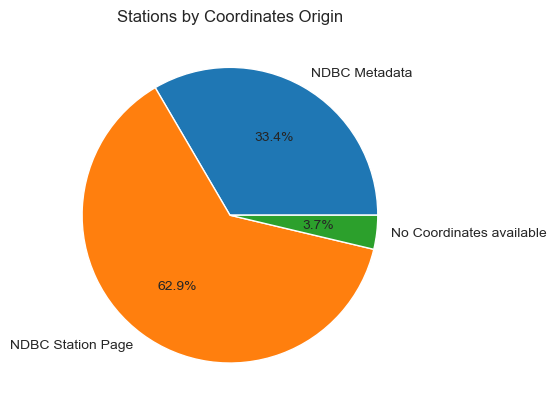

In [22]:
import matplotlib.pyplot as plt

# Create a pie chart
fig, ax = plt.subplots()
ax.pie([num_stations_c_file, num_stations_c_web, num_stations_no_c],
       labels=["NDBC Metadata",
               "NDBC Station Page",
               "No Coordinates available"],
       autopct='%1.1f%%',
       )

# Add a title
ax.set_title('Stations by Coordinates Origin')
# Display the chart
plt.show()

In [23]:
files_df_1 = metadata_1.dropna(subset=['lat', 'lon']).drop(["lat", "lon"], axis=1)
files_df_2 = metadata_2.dropna(subset=['lat', 'lon']).drop(["lat", "lon"], axis=1)
files_df_3 = metadata_3.dropna(subset=['lat', 'lon']).drop(["lat", "lon"], axis=1)

sum_files = metadata_0.sum().sum()
sum_files_md_file = files_df_1.sum().sum()
sum_files_md_file_and_web = files_df_2.sum().sum()

print("Sum of available files: ", sum_files)
print("Files with coordinates out of ndbc-metadata file: ", sum_files_md_file)
print("Files with coordinates out of station_page: ", sum_files_md_file_and_web - sum_files_md_file)
print("Files without coordinates: ", sum_files - sum_files_md_file_and_web)

Sum of available files:  14940
Files with coordinates out of ndbc-metadata file:  5580
Files with coordinates out of station_page:  9144
Files without coordinates:  216


In [24]:
metadata_0[range(1970, 1997)]

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996
0y2w3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4cONF,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4h361,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4h363,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4h364,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yabp4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
yata2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ygnn6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ykrv2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


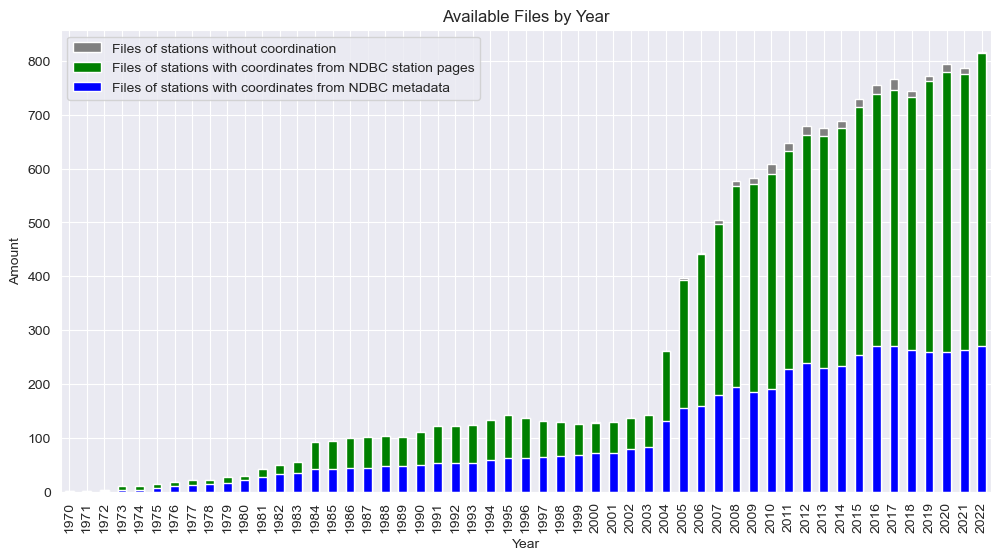

In [25]:
fig, ax = plt.subplots(figsize=(12,6))

metadata_0.sum().plot(kind='bar', color="gray", label='Files of stations without coordination')
files_df_2.sum().plot(kind='bar', color="green", label="Files of stations with coordinates from NDBC station pages")
files_df_1.sum().plot(kind='bar', color="blue", label="Files of stations with coordinates from NDBC metadata")

plt.title('Available Files by Year')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend()

# Show the plot
plt.show()

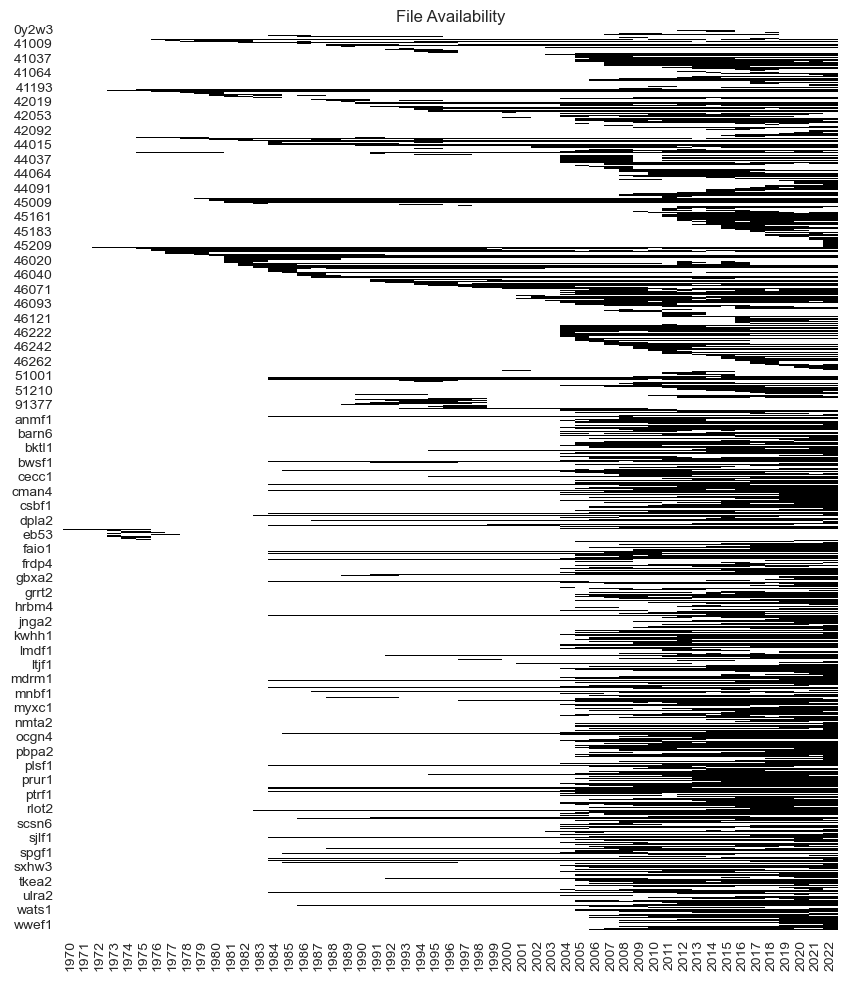

In [26]:
import seaborn as sns

# Create a new figure with a size of 6x4 inches
#plt.figure(figsize=(20, 60))
plt.figure(figsize=(10, 11.69))

# Create a heatmap of the DataFrame
sns.heatmap(files_df_3.astype(bool), cmap='binary', annot=False, cbar=False)

plt.title("File Availability")
plt.show()

## White = files are available!

---
# Analyse stations that have been removed

In [25]:
print("Stations with no coordinates: \n")
print(metadata_2[metadata_2['lat'].isnull()].index)

Stations with no coordinates: 

Index(['4cONF', '4h361', '4h363', '4h364', '4h365', '4h390', '4h394', '32st1',
       '32st2', '41nt1', '41nt2', '42a02', '42a03', '42otp', '43WSL', '46a35',
       '46a54', '51wh1', '51wh2', '53ANF', '53MKF', '42360', '42361', '42362',
       '42363', '42364', '42365', '42369', '42370', '42374', '42375', '42376',
       '42390', '42392', '42394', '42395', '42887', '42902', '46074', '47072',
       'a002e', 'a025w', 'b040z', 'et01z', 'f022l', 'misma', 'plsfa', 'q004w'],
      dtype='object')


In [28]:
metadata_2[metadata_2['lat'].isna()]

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2015,2016,2017,2018,2019,2020,2021,2022,lat,lon
4cONF,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,NaN,NaN
4h361,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,True,False,NaN,NaN
4h363,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,NaN,NaN
4h364,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,NaN,NaN
4h365,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,NaN,NaN
4h390,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,True,False,NaN,NaN
4h394,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,True,False,NaN,NaN
32st1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,NaN,NaN
32st2,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,False,NaN,NaN
41nt1,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,NaN,NaN


In [31]:
metadata_2[metadata_2['lat'].isna()].sum()

1970      0
1971      0
1972      0
1973      0
1974      0
1975      0
1976      0
1977      0
1978      0
1979      0
1980      0
1981      0
1982      0
1983      0
1984      0
1985      0
1986      0
1987      0
1988      0
1989      0
1990      0
1991      0
1992      0
1993      0
1994      0
1995      0
1996      1
1997      0
1998      0
1999      0
2000      3
2001      1
2002      0
2003      1
2004      0
2005      3
2006      2
2007      7
2008      9
2009     11
2010     18
2011     15
2012     17
2013     15
2014     13
2015     15
2016     16
2017     21
2018     11
2019      9
2020     15
2021     10
2022      3
lat     0.0
lon     0.0
dtype: object

In [1]:
fig, ax = plt.subplots(figsize=(12,6))

metadata_2[metadata_2['lat'].isna()].sum().plot(kind='bar', color="gray", label='Files without coordination')

plt.title('Available Files by Year (Files with missing coordinates)')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend()

# Show the plot
plt.show()

NameError: name 'plt' is not defined